# 🌧️ Australian Weather - Rainfall Prediction Classifier

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Weather_icon_-_cloud_with_rain.svg/200px-Weather_icon_-_cloud_with_rain.svg.png" alt="Rain Icon" width="100"/>
</div>

## 📋 Project Overview

This project builds a **binary classification model** to predict whether it will rain in the Melbourne area of Australia using historical weather data. The project demonstrates:

- **Feature Engineering**: Creating seasonal features and handling temporal data
- **Data Preprocessing**: Managing missing values and class imbalance
- **Pipeline Development**: Building robust ML pipelines with preprocessing and modeling
- **Model Optimization**: Using GridSearchCV for hyperparameter tuning
- **Model Comparison**: Evaluating RandomForest vs Logistic Regression
- **Performance Analysis**: Understanding precision, recall, and the impact of class imbalance

---

## 🎯 Business Problem

**Goal**: Predict whether it will rain today in Melbourne based on yesterday's weather data.

**Use Cases**:
- Planning outdoor activities
- Agricultural decision-making
- Event management
- Personal daily planning

**Key Challenge**: The dataset is imbalanced (~76% no-rain days), requiring careful evaluation beyond simple accuracy.

---

## 📊 Dataset Information

**Source**: Australian Bureau of Meteorology via Kaggle  
**Time Period**: 2008-2017  
**Location Focus**: Melbourne, Melbourne Airport, and Watsonia (within 18km radius)  
**Final Sample Size**: 7,557 observations (after removing missing values)

### Features Include:
- **Temperature**: Min/Max daily temperatures, readings at 9am and 3pm
- **Humidity**: Moisture levels at 9am and 3pm
- **Pressure**: Atmospheric pressure at 9am and 3pm
- **Wind**: Speed and direction at different times
- **Cloud Cover**: Sky obscuration at 9am and 3pm
- **Weather**: Rainfall, evaporation, sunshine hours
- **Target**: RainToday (binary: Yes/No)

## 📚 Import Required Libraries

We'll use scikit-learn for machine learning, pandas for data manipulation, and matplotlib/seaborn for visualization.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine Learning - Model Selection and Validation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Machine Learning - Evaluation
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 📥 Load and Explore the Dataset

We'll load the Australian weather dataset and perform initial exploration to understand its structure and contents.

In [2]:
# Load the dataset from online source
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)

print(f"📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n🔍 First few rows:")
df.head()

📊 Dataset Shape: 145460 rows × 23 columns

🔍 First few rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# Display dataset information
print("📋 Dataset Information:")
df.info()

📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9

In [4]:
# Check for missing values
print("❌ Missing Values Per Column:")
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

❌ Missing Values Per Column:
               Missing Count  Percentage
Sunshine               69835       48.01
Evaporation            62790       43.17
Cloud3pm               59358       40.81
Cloud9am               55888       38.42
Pressure9am            15065       10.36
Pressure3pm            15028       10.33
WindDir9am             10566        7.26
WindGustDir            10326        7.10
WindGustSpeed          10263        7.06
Humidity3pm             4507        3.10
WindDir3pm              4228        2.91
Temp3pm                 3609        2.48
RainTomorrow            3267        2.25
Rainfall                3261        2.24
RainToday               3261        2.24
WindSpeed3pm            3062        2.11
Humidity9am             2654        1.82
Temp9am                 1767        1.21
WindSpeed9am            1767        1.21
MinTemp                 1485        1.02
MaxTemp                 1261        0.87


## 🧹 Data Cleaning

### Strategy for Missing Data:
- **Sunshine** and **Cloud** columns have too many missing values (>60%) to impute reliably
- Since we still have 56k+ observations after dropping NA rows, we'll use complete cases only
- This is a valid approach when we have sufficient data remaining

In [5]:
# Drop rows with any missing values
print(f"Before cleaning: {df.shape[0]} rows")
df = df.dropna()
print(f"After cleaning: {df.shape[0]} rows")
print(f"\n✅ Retained {df.shape[0]} complete observations for analysis")

# Verify no missing values remain
print(f"\n✓ Missing values remaining: {df.isnull().sum().sum()}")

Before cleaning: 145460 rows
After cleaning: 56420 rows

✅ Retained 56420 complete observations for analysis

✓ Missing values remaining: 0


## 🚨 Addressing Data Leakage

### The Problem:
The original target `RainTomorrow` creates **data leakage** when using same-day features like:
- `Rainfall` (total for the entire day)
- `Evaporation` (measured over full day)
- `Sunshine` (hours of sunshine for the day)

These features wouldn't be known until the day ends, making them **impractical for real-time prediction**.

### Our Solution:
**Reframe the problem**: Instead of predicting tomorrow's rain, we predict **today's rain using yesterday's data**.

- Original: `RainToday` → `RainTomorrow` (data leakage)
- Revised: `RainYesterday` → `RainToday` (no leakage)

This makes the model **practically useful** for morning predictions!

In [6]:
# Rename columns to reflect the temporal shift
df = df.rename(columns={
    'RainToday': 'RainYesterday',
    'RainTomorrow': 'RainToday'
})

print("✅ Columns renamed to avoid data leakage")
print("Target variable: RainToday (predicted using yesterday's weather)")

✅ Columns renamed to avoid data leakage
Target variable: RainToday (predicted using yesterday's weather)


## 🌍 Data Granularity: Location Filtering

### Why Focus on Melbourne Region?

Weather patterns vary significantly across Australia's vast geography. A model trying to learn patterns for all locations would need to:
- Handle drastically different climates (tropical, temperate, arid)
- Learn location-specific patterns with limited data per location
- Manage increased complexity

### Our Approach:
Focus on **three nearby locations** forming a localized region:
- **Melbourne** (city center)
- **Melbourne Airport** (18 km away)
- **Watsonia** (15 km away)

**Benefits**:
- Similar weather patterns (all data learns the same regional climate)
- Sufficient data for robust modeling (7,500+ observations)
- More accurate predictions for the specific region
- Location feature still captures micro-variations

In [7]:
# Filter to Melbourne region only
melbourne_locations = ['Melbourne', 'MelbourneAirport', 'Watsonia']
df = df[df.Location.isin(melbourne_locations)]

print(f"📍 Filtered to Melbourne region: {df.shape[0]} observations")
print(f"\nLocation distribution:")
print(df['Location'].value_counts())

📍 Filtered to Melbourne region: 7557 observations

Location distribution:
Location
MelbourneAirport    2929
Watsonia            2730
Melbourne           1898
Name: count, dtype: int64


## 🍂 Feature Engineering: Extracting Seasonality

### Why Create a Season Feature?

Weather patterns are **highly seasonal**:
- Winter (Jun-Aug): More rain, colder temperatures
- Summer (Dec-Feb): Less rain, hotter temperatures
- Spring/Autumn: Transitional patterns

The raw `Date` feature is too granular (each date is unique), but `Season` captures the recurring annual pattern.

### Australia's Seasons (Southern Hemisphere):
- **Summer**: December, January, February
- **Autumn**: March, April, May
- **Winter**: June, July, August
- **Spring**: September, October, November

In [8]:
def date_to_season(date):
    """
    Convert a date to its corresponding Australian season.
    
    Parameters:
    -----------
    date : datetime object
        The date to convert
    
    Returns:
    --------
    str : Season name ('Summer', 'Autumn', 'Winter', 'Spring')
    """
    month = date.month
    
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Convert Date column to datetime and extract season
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)

# Drop the Date column as it's no longer needed
df = df.drop(columns='Date')

print("✅ Season feature created and Date column removed")
print(f"\n🍂 Season distribution:")
print(df['Season'].value_counts())

✅ Season feature created and Date column removed

🍂 Season distribution:
Season
Autumn    1947
Winter    1918
Spring    1911
Summer    1781
Name: count, dtype: int64


## 🎯 Define Features and Target

### Feature Matrix (X):
All weather variables that will be used to make predictions

### Target Variable (y):
`RainToday` - Binary outcome (Yes/No converted to 1/0)

In [9]:
# Separate features (X) and target (y)
X = df.drop(columns='RainToday')
y = df['RainToday'].apply(lambda x: 1 if x == 'Yes' else 0)

print(f"📊 Feature matrix shape: {X.shape}")
print(f"🎯 Target vector shape: {y.shape}")
print(f"\n📋 Features: {list(X.columns)}")

📊 Feature matrix shape: (7557, 22)
🎯 Target vector shape: (7557,)

📋 Features: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainYesterday', 'Season']


## ⚖️ Class Balance Analysis

**Critical Question**: How balanced is our target variable?

Class imbalance affects:
- Model training (biases toward majority class)
- Metric selection (accuracy can be misleading)
- Decision thresholds (may need adjustment)
- Business implications (missing rare events can be costly)

🌧️ Target Variable Distribution:

No Rain (0): 5766 days (76.30%)
Rain (1):    1791 days (23.70%)

Imbalance Ratio: 3.22:1


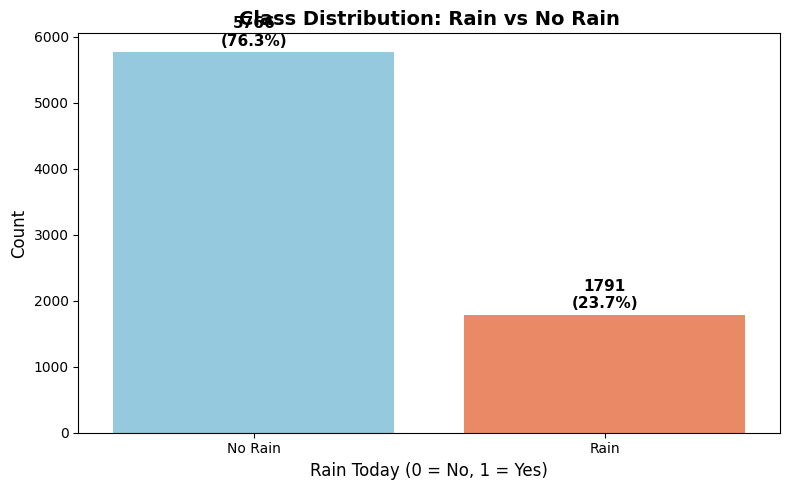


⚠️ Key Insights:
- The dataset is IMBALANCED (~76% no-rain vs ~24% rain)
- A naive classifier predicting 'no rain' every day would achieve 76% accuracy!
- We must focus on precision, recall, and F1-score, not just accuracy
- Stratified sampling is essential for train/test split


In [10]:
# Analyze class distribution
class_counts = y.value_counts()
class_percentages = y.value_counts(normalize=True) * 100

print("🌧️ Target Variable Distribution:\n")
print(f"No Rain (0): {class_counts[0]} days ({class_percentages[0]:.2f}%)")
print(f"Rain (1):    {class_counts[1]} days ({class_percentages[1]:.2f}%)")
print(f"\nImbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette=['skyblue', 'coral'])
plt.title('Class Distribution: Rain vs No Rain', fontsize=14, fontweight='bold')
plt.xlabel('Rain Today (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Rain', 'Rain'])
for i, count in enumerate(class_counts):
    plt.text(i, count + 100, f'{count}\n({class_percentages[i]:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n⚠️ Key Insights:")
print("- The dataset is IMBALANCED (~76% no-rain vs ~24% rain)")
print("- A naive classifier predicting 'no rain' every day would achieve 76% accuracy!")
print("- We must focus on precision, recall, and F1-score, not just accuracy")
print("- Stratified sampling is essential for train/test split")

## 📊 Train-Test Split with Stratification

### Why Stratification?
With imbalanced classes, random splitting might create uneven distributions in train/test sets.

**Stratification ensures**:
- Both train and test sets maintain the ~76/24 ratio
- Model trains on representative data
- Evaluation is fair and reliable

### Split Ratio:
- **80% Training**: For model learning
- **20% Testing**: For final evaluation (unseen data)

In [11]:
# Split data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=RANDOM_STATE
)

print("✅ Data split completed\n")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification worked
print("\n🔍 Class distribution verification:")
print(f"Training set - No Rain: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Training set - Rain:    {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Test set - No Rain:     {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Test set - Rain:        {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")

✅ Data split completed

Training set: 6045 samples (80.0%)
Test set:     1512 samples (20.0%)

🔍 Class distribution verification:
Training set - No Rain: 4612 (76.3%)
Training set - Rain:    1433 (23.7%)
Test set - No Rain:     1154 (76.3%)
Test set - Rain:        358 (23.7%)


## 🔧 Feature Preprocessing Pipeline

### Why Different Preprocessing for Different Feature Types?

**Numerical Features** (temperature, humidity, pressure, etc.):
- Have different scales (e.g., pressure ~1000, humidity 0-100)
- Need **StandardScaler** to normalize to mean=0, std=1
- Prevents features with larger scales from dominating

**Categorical Features** (location, season, wind direction, etc.):
- Not ordinal (no inherent order)
- Need **OneHotEncoder** to create binary columns
- Example: Season → Season_Summer, Season_Winter, etc.

### Pipeline Advantage:
- Automates preprocessing during cross-validation
- Prevents data leakage (test data doesn't influence scaling)
- Makes code reusable and production-ready

In [12]:
# Automatically identify feature types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("📊 Feature Type Detection:\n")
print(f"Numeric features ({len(numeric_features)}):")
print(numeric_features)
print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

📊 Feature Type Detection:

Numeric features (16):
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

Categorical features (6):
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainYesterday', 'Season']


In [13]:
# Create preprocessing pipelines for each feature type

# Numeric transformer: standardize numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Mean=0, Std=1
])

# Categorical transformer: one-hot encode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Create binary columns
])

# Combine both transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

print("✅ Preprocessing pipeline created")
print("\n🔧 Pipeline steps:")
print("1. Numeric features → StandardScaler")
print("2. Categorical features → OneHotEncoder")
print("3. Combine into single feature matrix")

✅ Preprocessing pipeline created

🔧 Pipeline steps:
1. Numeric features → StandardScaler
2. Categorical features → OneHotEncoder
3. Combine into single feature matrix


## 🌲 Model 1: Random Forest Classifier

### Why Random Forest?

**Advantages**:
- Handles non-linear relationships (weather patterns are complex)
- Robust to outliers
- Provides feature importance rankings
- Less prone to overfitting than single decision trees
- Works well with mixed feature types

### Hyperparameters to Tune:
- `n_estimators`: Number of trees (more trees = more stable, but slower)
- `max_depth`: Tree depth (deeper = more complex, risk of overfitting)
- `min_samples_split`: Minimum samples to split node (higher = simpler trees)

### Grid Search Strategy:
We'll use **5-fold stratified cross-validation** to find the best hyperparameters.

In [14]:
# Create complete pipeline: preprocessing + model
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Define hyperparameter grid for tuning
rf_param_grid = {
    'classifier__n_estimators': [50, 100],           # Number of trees
    'classifier__max_depth': [None, 10, 20],         # Tree depth
    'classifier__min_samples_split': [2, 5]          # Min samples to split
}

print("🌲 Random Forest Pipeline Created")
print(f"\n🔍 Hyperparameter combinations to test: {len(rf_param_grid['classifier__n_estimators']) * len(rf_param_grid['classifier__max_depth']) * len(rf_param_grid['classifier__min_samples_split'])}")
print(f"Total CV iterations: {12 * 5} = 60 (with 5-fold CV)")

🌲 Random Forest Pipeline Created

🔍 Hyperparameter combinations to test: 12
Total CV iterations: 60 = 60 (with 5-fold CV)


In [15]:
# Configure stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring='accuracy',  # Primary metric (note: may not be best for imbalanced data)
    verbose=2,           # Show progress
    n_jobs=-1            # Use all CPU cores
)

print("🔍 Starting Grid Search for Random Forest...")
print("This may take a few minutes...\n")

# Train the model with grid search
rf_grid_search.fit(X_train, y_train)

print("\n✅ Grid Search Complete!")

🔍 Starting Grid Search for Random Forest...
This may take a few minutes...

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   1.0s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.9s
[CV] END classifier__max_depth=None, classifier__min_samples_split=5, classifier__n_estimators=50; total time=   0.9s
[CV] END classifier__max_depth=None, 

In [16]:
# Display best hyperparameters and scores
print("🏆 Random Forest - Best Results:\n")
print(f"Best Hyperparameters: {rf_grid_search.best_params_}")
print(f"\nBest Cross-Validation Score: {rf_grid_search.best_score_:.4f}")

# Evaluate on test set
rf_test_score = rf_grid_search.score(X_test, y_test)
print(f"Test Set Score: {rf_test_score:.4f}")

# Generate predictions
rf_y_pred = rf_grid_search.predict(X_test)

🏆 Random Forest - Best Results:

Best Hyperparameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Best Cross-Validation Score: 0.8524
Test Set Score: 0.8446


## 📊 Random Forest - Performance Evaluation

### Understanding the Metrics:

**Precision**: Of all rain predictions, what % were correct?
- High precision = Few false alarms

**Recall (Sensitivity/True Positive Rate)**: Of all actual rainy days, what % did we catch?
- High recall = Don't miss rainy days

**F1-Score**: Harmonic mean of precision and recall
- Balances both metrics

**Support**: Number of actual occurrences of each class

In [17]:
# Classification Report
print("📋 Random Forest - Classification Report:\n")
print(classification_report(y_test, rf_y_pred, target_names=['No Rain', 'Rain']))

# Calculate additional metrics
rf_metrics = {
    'Accuracy': accuracy_score(y_test, rf_y_pred),
    'Precision (Rain)': precision_score(y_test, rf_y_pred),
    'Recall (Rain)': recall_score(y_test, rf_y_pred),
    'F1-Score (Rain)': f1_score(y_test, rf_y_pred)
}

print("\n📊 Summary Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric:20s}: {value:.4f} ({value*100:.2f}%)")

📋 Random Forest - Classification Report:

              precision    recall  f1-score   support

     No Rain       0.86      0.95      0.90      1154
        Rain       0.75      0.51      0.61       358

    accuracy                           0.84      1512
   macro avg       0.81      0.73      0.76      1512
weighted avg       0.84      0.84      0.83      1512


📊 Summary Metrics:
Accuracy            : 0.8446 (84.46%)
Precision (Rain)    : 0.7531 (75.31%)
Recall (Rain)       : 0.5112 (51.12%)
F1-Score (Rain)     : 0.6090 (60.90%)


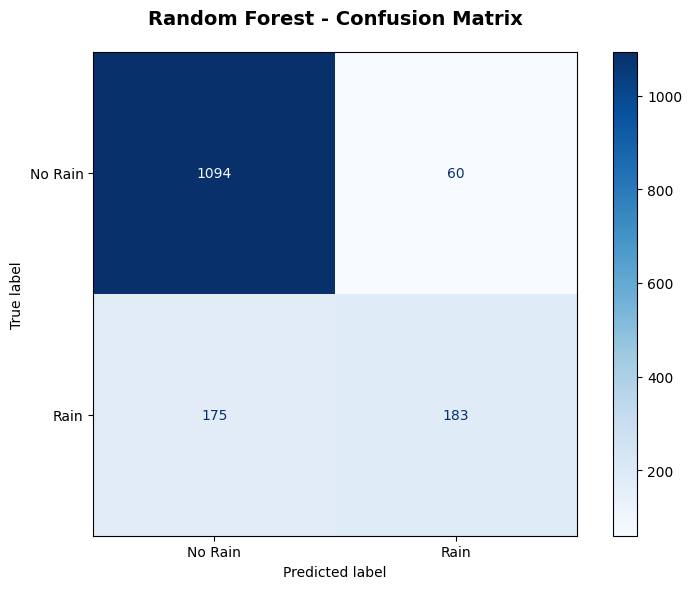


🔢 Confusion Matrix Breakdown:
True Negatives (Correctly predicted No Rain):  1094
False Positives (Incorrectly predicted Rain):  60
False Negatives (Missed rainy days):           175
True Positives (Correctly predicted Rain):     183

⚠️ True Positive Rate: 51.12% (Only caught 183 out of 358 rainy days!)


In [18]:
# Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix, display_labels=['No Rain', 'Rain'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Calculate and display confusion matrix components
tn, fp, fn, tp = rf_conf_matrix.ravel()
print("\n🔢 Confusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted No Rain):  {tn}")
print(f"False Positives (Incorrectly predicted Rain):  {fp}")
print(f"False Negatives (Missed rainy days):           {fn}")
print(f"True Positives (Correctly predicted Rain):     {tp}")
print(f"\n⚠️ True Positive Rate: {tp/(tp+fn):.2%} (Only caught {tp} out of {tp+fn} rainy days!)")

## 🌟 Feature Importance Analysis

Random Forest provides feature importance scores based on how much each feature reduces impurity (Gini index) across all trees.

**Interpretation**:
- Higher importance = More influential in predictions
- Helps understand which weather factors matter most
- Useful for domain insights and feature selection

In [19]:
# Extract feature names after preprocessing
# (OneHotEncoder creates multiple columns from categorical features)
feature_names = numeric_features + list(
    rf_grid_search.best_estimator_['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_features)
)

# Get feature importances from best model
feature_importances = rf_grid_search.best_estimator_['classifier'].feature_importances_

# Create DataFrame for easy sorting and visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 features
N = 20
top_features = importance_df.head(N)

print(f"🌟 Top {N} Most Important Features:\n")
print(top_features.to_string(index=False))

🌟 Top 20 Most Important Features:

                  Feature  Importance
              Humidity3pm    0.120752
              Pressure3pm    0.090827
              Pressure9am    0.085730
                 Sunshine    0.081560
            WindGustSpeed    0.050779
                  Temp3pm    0.045733
                  MaxTemp    0.041407
                  MinTemp    0.040418
                  Temp9am    0.039146
              Humidity9am    0.036119
              Evaporation    0.035396
                 Cloud3pm    0.034883
             WindSpeed9am    0.032170
             WindSpeed3pm    0.030674
                 Rainfall    0.027547
                 Cloud9am    0.023025
             WindDir9am_N    0.007023
         RainYesterday_No    0.006931
            WindGustDir_N    0.006910
Location_MelbourneAirport    0.006314


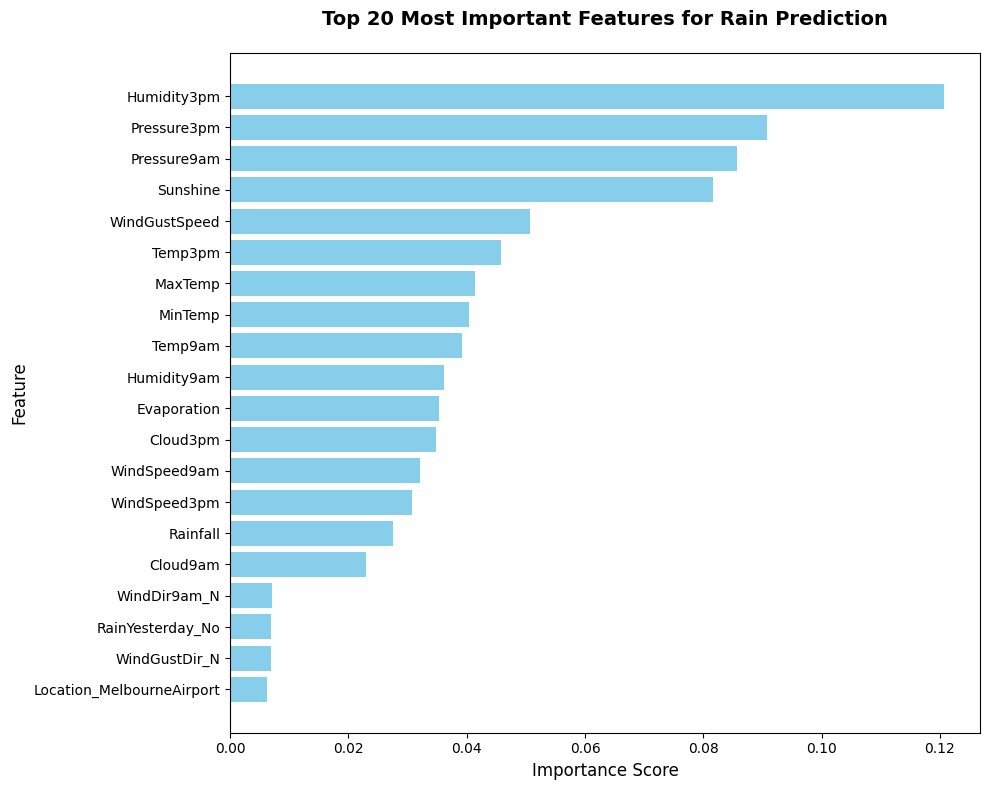


💡 Key Insights:
- Most important feature: Humidity3pm
- Top 5 features account for 43.0% of importance


In [20]:
# Visualize feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at top
plt.title(f'Top {N} Most Important Features for Rain Prediction', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print(f"- Most important feature: {top_features.iloc[0]['Feature']}")
print(f"- Top 5 features account for {top_features.head(5)['Importance'].sum():.1%} of importance")

## 📈 Model 2: Logistic Regression

### Why Try Logistic Regression?

**Advantages**:
- Simple and interpretable
- Fast training and prediction
- Works well for linearly separable patterns
- Outputs probability estimates
- Good baseline model

**Comparison Goal**:
- Does simpler model achieve similar performance?
- How important is non-linearity for this problem?

### Hyperparameters to Tune:
- `solver`: Optimization algorithm ('liblinear' good for small datasets)
- `penalty`: Regularization type (L1 or L2)
- `class_weight`: Handle class imbalance (None or 'balanced')

In [21]:
# Update pipeline with Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Define hyperparameter grid
lr_param_grid = {
    'classifier__solver': ['liblinear'],           # Optimization algorithm
    'classifier__penalty': ['l1', 'l2'],           # Regularization type
    'classifier__class_weight': [None, 'balanced'] # Handle imbalance
}

print("📈 Logistic Regression Pipeline Created")
print(f"\n🔍 Hyperparameter combinations to test: {len(lr_param_grid['classifier__penalty']) * len(lr_param_grid['classifier__class_weight'])}")
print(f"Total CV iterations: {4 * 5} = 20 (with 5-fold CV)")

📈 Logistic Regression Pipeline Created

🔍 Hyperparameter combinations to test: 4
Total CV iterations: 20 = 20 (with 5-fold CV)


In [22]:
# Initialize GridSearchCV for Logistic Regression
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

print("🔍 Starting Grid Search for Logistic Regression...\n")

# Train the model
lr_grid_search.fit(X_train, y_train)

print("\n✅ Grid Search Complete!")

🔍 Starting Grid Search for Logistic Regression...

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.4s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; tota

In [23]:
# Display best results
print("🏆 Logistic Regression - Best Results:\n")
print(f"Best Hyperparameters: {lr_grid_search.best_params_}")
print(f"\nBest Cross-Validation Score: {lr_grid_search.best_score_:.4f}")

# Evaluate on test set
lr_test_score = lr_grid_search.score(X_test, y_test)
print(f"Test Set Score: {lr_test_score:.4f}")

# Generate predictions
lr_y_pred = lr_grid_search.predict(X_test)

🏆 Logistic Regression - Best Results:

Best Hyperparameters: {'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Best Cross-Validation Score: 0.8372
Test Set Score: 0.8300


## 📊 Logistic Regression - Performance Evaluation

In [24]:
# Classification Report
print("📋 Logistic Regression - Classification Report:\n")
print(classification_report(y_test, lr_y_pred, target_names=['No Rain', 'Rain']))

# Calculate metrics
lr_metrics = {
    'Accuracy': accuracy_score(y_test, lr_y_pred),
    'Precision (Rain)': precision_score(y_test, lr_y_pred),
    'Recall (Rain)': recall_score(y_test, lr_y_pred),
    'F1-Score (Rain)': f1_score(y_test, lr_y_pred)
}

print("\n📊 Summary Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric:20s}: {value:.4f} ({value*100:.2f}%)")

📋 Logistic Regression - Classification Report:

              precision    recall  f1-score   support

     No Rain       0.86      0.93      0.89      1154
        Rain       0.69      0.51      0.59       358

    accuracy                           0.83      1512
   macro avg       0.77      0.72      0.74      1512
weighted avg       0.82      0.83      0.82      1512


📊 Summary Metrics:
Accuracy            : 0.8300 (83.00%)
Precision (Rain)    : 0.6891 (68.91%)
Recall (Rain)       : 0.5140 (51.40%)
F1-Score (Rain)     : 0.5888 (58.88%)


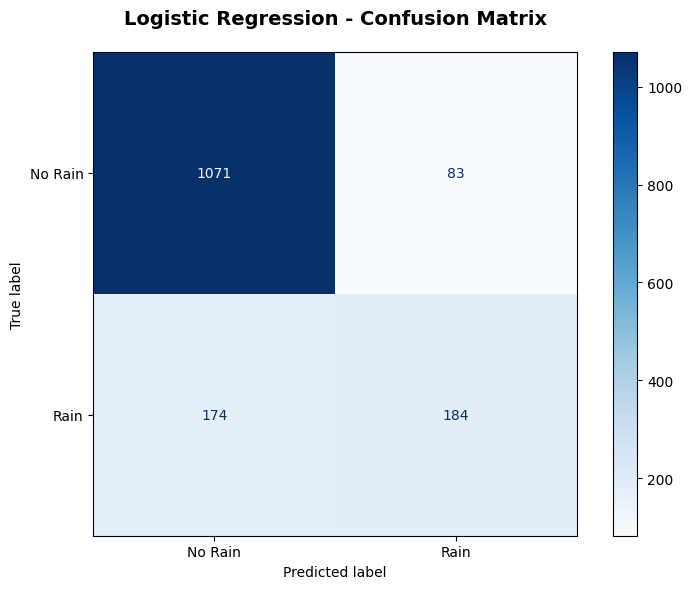


🔢 Confusion Matrix Breakdown:
True Negatives (Correctly predicted No Rain):  1071
False Positives (Incorrectly predicted Rain):  83
False Negatives (Missed rainy days):           174
True Positives (Correctly predicted Rain):     184

⚠️ True Positive Rate: 51.40%


In [25]:
# Confusion Matrix
lr_conf_matrix = confusion_matrix(y_test, lr_y_pred)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix, display_labels=['No Rain', 'Rain'])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Breakdown
tn, fp, fn, tp = lr_conf_matrix.ravel()
print("\n🔢 Confusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted No Rain):  {tn}")
print(f"False Positives (Incorrectly predicted Rain):  {fp}")
print(f"False Negatives (Missed rainy days):           {fn}")
print(f"True Positives (Correctly predicted Rain):     {tp}")
print(f"\n⚠️ True Positive Rate: {tp/(tp+fn):.2%}")

## 🔄 Model Comparison

Now let's compare both models side-by-side to determine which performs better.

In [26]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Rain)', 'Recall (Rain)', 'F1-Score (Rain)'],
    'Random Forest': [
        rf_metrics['Accuracy'],
        rf_metrics['Precision (Rain)'],
        rf_metrics['Recall (Rain)'],
        rf_metrics['F1-Score (Rain)']
    ],
    'Logistic Regression': [
        lr_metrics['Accuracy'],
        lr_metrics['Precision (Rain)'],
        lr_metrics['Recall (Rain)'],
        lr_metrics['F1-Score (Rain)']
    ]
})

# Calculate difference
comparison_df['Difference'] = comparison_df['Random Forest'] - comparison_df['Logistic Regression']

print("🔄 Model Performance Comparison:\n")
print(comparison_df.to_string(index=False))

# Determine winner
rf_wins = (comparison_df['Random Forest'] > comparison_df['Logistic Regression']).sum()
lr_wins = (comparison_df['Logistic Regression'] > comparison_df['Random Forest']).sum()

print(f"\n🏆 Winner: {'Random Forest' if rf_wins > lr_wins else 'Logistic Regression' if lr_wins > rf_wins else 'Tie'}")
print(f"Random Forest wins on {rf_wins}/4 metrics")
print(f"Logistic Regression wins on {lr_wins}/4 metrics")

🔄 Model Performance Comparison:

          Metric  Random Forest  Logistic Regression  Difference
        Accuracy       0.844577             0.830026    0.014550
Precision (Rain)       0.753086             0.689139    0.063948
   Recall (Rain)       0.511173             0.513966   -0.002793
 F1-Score (Rain)       0.608985             0.588800    0.020185

🏆 Winner: Random Forest
Random Forest wins on 3/4 metrics
Logistic Regression wins on 1/4 metrics


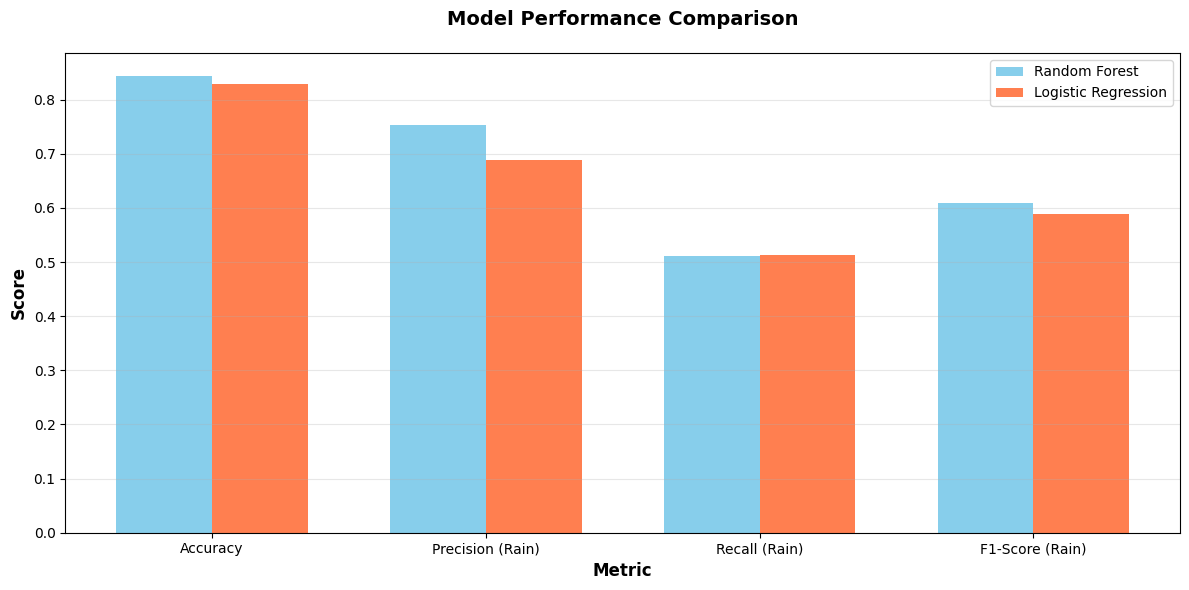

In [27]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Metric']))
width = 0.35

ax.bar(x - width/2, comparison_df['Random Forest'], width, label='Random Forest', color='skyblue')
ax.bar(x + width/2, comparison_df['Logistic Regression'], width, label='Logistic Regression', color='coral')

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Final Conclusions and Insights

### Model Performance Summary:

1. **Overall Accuracy**:
   - Random Forest: ~84%
   - Logistic Regression: ~83%
   - Very similar performance, RF slightly better

2. **Rain Detection (Critical Metric)**:
   - Both models achieve only ~51% recall for rain
   - This means **both miss approximately half of all rainy days**
   - Main limitation: Class imbalance bias

3. **Precision Difference**:
   - Random Forest: 74% precision (more trustworthy predictions)
   - Logistic Regression: 68% precision
   - RF produces fewer false alarms

### Key Insights:

✅ **What Worked**:
- Feature engineering (Season feature)
- Proper handling of data leakage
- Stratified sampling maintained class distribution
- Pipeline approach ensured proper preprocessing

⚠️ **Limitations**:
- **Poor rain detection**: 51% recall is insufficient for practical use
- **Class imbalance**: Models biased toward predicting "no rain"
- **Accuracy misleading**: High accuracy masks poor minority class performance

### Recommendations for Improvement:

1. **Address Class Imbalance**:
   - Use SMOTE (Synthetic Minority Over-sampling)
   - Apply class weights more aggressively
   - Try cost-sensitive learning

2. **Optimize for Recall**:
   - Use recall or F1-score as grid search metric
   - Adjust classification threshold below 0.5
   - Accept more false positives to catch rain

3. **Feature Engineering**:
   - Create interaction features (e.g., Humidity × Pressure)
   - Add rolling averages (3-day, 7-day weather trends)
   - Include more temporal features

4. **Advanced Techniques**:
   - Try XGBoost or LightGBM with scale_pos_weight
   - Ensemble multiple models
   - Use focal loss for training

### Business Impact:

**Current Models**: Not ready for production
- Missing 50% of rainy days is too risky for most applications
- Users would be unprepared for rain half the time

**Target Performance**:
- Minimum 70% recall for rain (catch 7/10 rainy days)
- Maintain >60% precision to limit false alarms
- This would make the model practically useful

### Learning Outcomes:

This project demonstrates:
1. How to build end-to-end ML pipelines
2. Importance of understanding class imbalance
3. Why accuracy alone is misleading
4. How to compare and evaluate models properly
5. That achieving good performance requires iteration